<a href="https://colab.research.google.com/github/jiaminho/Pedestrian-Trajectory-Prediction-LSTM/blob/main/Pedestrian_Trajectory_Prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CITS5017 Deep Learning Project 1

Jia Min Ho (23337561)

# Rename to Ho_JiaMin-proj2.ipynb

Import libraries

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load file

In [54]:
def load_data(filename):
  with open(filename, "rb") as f:
    train = np.load(f)
    val = np.load(f)
  return train, val

train_set, val_set = load_data("zara1.npy")

In [55]:
train_set.shape

(26507, 20, 2)

train set is a 3D tensor of the shape (26507, 20, 2)

In [56]:
val_set.shape

(2315, 20, 2)

val set is also a 3D tensor of the shape (2315, 20, 2)

In [57]:
train_set[:2]

array([[[-0.31367778,  0.06750966],
        [-0.29939284,  0.04183492],
        [-0.28788528,  0.02332389],
        [-0.27795722,  0.00511593],
        [-0.27771266, -0.01810555],
        [-0.27427557, -0.0401845 ],
        [-0.26811742, -0.06929811],
        [-0.26960516, -0.09556106],
        [-0.2664506 , -0.12253553],
        [-0.25403196, -0.15084949],
        [-0.2478035 , -0.17821016],
        [-0.24339741, -0.21024651],
        [-0.23582799, -0.24103601],
        [-0.22989552, -0.27321961],
        [-0.22685222, -0.30169945],
        [-0.21930551, -0.33237906],
        [-0.21320741, -0.36119077],
        [-0.21341177, -0.39253789],
        [-0.20912005, -0.42605787],
        [-0.20061589, -0.4666159 ]],

       [[-0.29939284,  0.04183492],
        [-0.28788528,  0.02332389],
        [-0.27795722,  0.00511593],
        [-0.27771266, -0.01810555],
        [-0.27427557, -0.0401845 ],
        [-0.26811742, -0.06929811],
        [-0.26960516, -0.09556106],
        [-0.2664506 , -0.1

## 1.

Split the trajectories into two parts: the observed part should contain the trajectory coordinates for
the first 12 frames; the future part should contain the trajectory coordinates for the remaining 8
frames.

In [58]:
def split_trajectories(data):
    # Observed part contains the trajectory coordinates for the first 12 frames
    observed = data[:, :12, :]
    # Future part contains the trajectory coordinates for the remaining 8 frames
    future = data[:, 12:, :]
    return observed, future

train_observed, train_future = split_trajectories(train_set)
val_observed, val_future = split_trajectories(val_set)


## 2.

Write a small function that takes in appropriate arguments so that it would randomly sample 30
trajectories and display them in 3 subplots (10 trajectories per subplot, to avoid crowdedness). The
observed part and the future part of each trajectory should be shown in different colours.
Call the function twice – for the training set then the validation set.

In [59]:
def display_sampled_trajectories(observed, true_future, predicted_future=None, title="Sampled Trajectories", seed=42):
    np.random.seed(seed)  # For reproducibility
    indices = np.random.choice(observed.shape[0], 30, replace=False)

    fig, axs = plt.subplots(3, 1, figsize=(5, 8))
    for i, ax in enumerate(axs):
        for j in range(10):
            index = indices[i*10 + j]
            ax.plot(observed[index, :, 0], observed[index, :, 1], color='blue', label='Observed' if j==0 else "")
            ax.plot(true_future[index, :, 0], true_future[index, :, 1], color='green', label='True Future' if j==0 else "")

            # Check if predicted_future is provided
            if predicted_future is not None:
                ax.plot(predicted_future[index, :, 0], predicted_future[index, :, 1], color='red', label='Predicted Future' if j==0 else "")

            ax.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

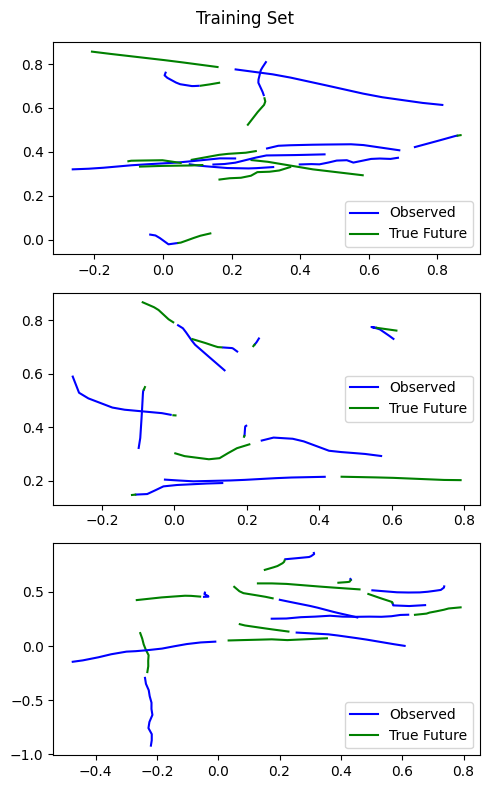

In [60]:
# Call the function for training set
display_sampled_trajectories(train_observed, train_future, title="Training Set")

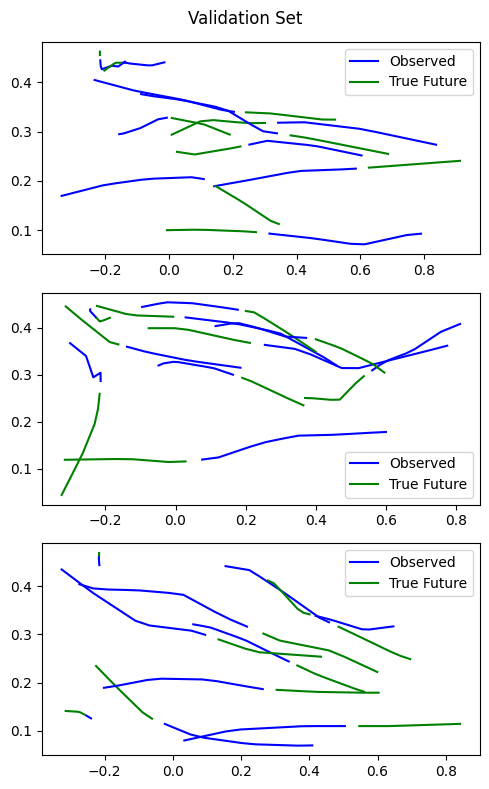

In [61]:
# Call the function for validation set
display_sampled_trajectories(val_observed, val_future, title="Validation Set")

## 3.

(iii) Implementation of the first LSTM model (30% (the mark includes parts (i) and (ii) above))
- Design an LSTM that has 1 to 2 layers and an appropriate number of neurons per layer.
This LSTM should be trained to take in the observed part of the trajectories and predict the
pedestrians’ 2D coordinates for just the first frame in the future part (i.e., predict one timestep
ahead). Show the architecture of your LSTM network.
- You will need to write a function using the formula given in Equation (1) and use it as the
loss function for compiling and training your network, e.g., def ADE(y true, y pred).
- Train your network for 100 epochs but use an early stopping callback and the validation set
to prevent over-training.
- Show the learning curves plot.
- As this LSTM network can predict only the pedestrians’ coordinates for one timestep ahead,
use a for loop to recursively predict the remaining 7 frames in the future part of the trajectories.
- Report the ADE and FDE of this network.
- Illustrate 30 randomly sampled trajectories in some subplots. The observed part, the ground
truth future part and the predicted future part of these trajectories should be shown in different
colours.
If you have the function for part (ii) above designed well, you should be able to reuse the
function here.

First LSTM model

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Design the LSTM
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(12, 2)),  # adjust the number of neurons if needed
    LSTM(32),
    Dense(2)  # To predict the x,y coordinates for the next timestep
])

model.summary()  # Show the architecture


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 64)            17152     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 29634 (115.76 KB)
Trainable params: 29634 (115.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Implement the ADE loss function:

In [45]:
def ADE(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)))

Compile and Train the Model with Early Stopping

In [46]:
# Compile the model
model.compile(optimizer='adam', loss=ADE)

# Early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(train_observed, train_future[:, 0, :],
                    validation_data=(val_observed, val_future[:, 0, :]),
                    epochs=100, callbacks=[early_stop], batch_size=32)


Epoch 1/100
829/829 [==============================] - 21s 18ms/step - loss: 0.0576 - val_loss: 0.0160
Epoch 2/100
829/829 [==============================] - 18s 22ms/step - loss: 0.0172 - val_loss: 0.0109
Epoch 3/100
829/829 [==============================] - 19s 23ms/step - loss: 0.0116 - val_loss: 0.0084
Epoch 4/100
829/829 [==============================] - 22s 26ms/step - loss: 0.0096 - val_loss: 0.0084
Epoch 5/100
829/829 [==============================] - 17s 20ms/step - loss: 0.0080 - val_loss: 0.0070
Epoch 6/100
829/829 [==============================] - 16s 19ms/step - loss: 0.0073 - val_loss: 0.0086
Epoch 7/100
829/829 [==============================] - 18s 21ms/step - loss: 0.0064 - val_loss: 0.0037
Epoch 8/100
829/829 [==============================] - 15s 18ms/step - loss: 0.0062 - val_loss: 0.0042
Epoch 9/100
829/829 [==============================] - 14s 17ms/step - loss: 0.0056 - val_loss: 0.0077
Epoch 10/100
829/829 [==============================] - 14s 17ms/step - l

Display the Learning Curves

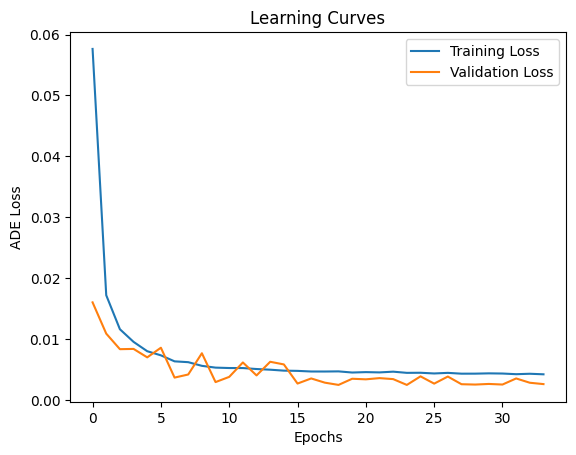

In [47]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('ADE Loss')
plt.title('Learning Curves')
plt.show()


Predict Remaining 7 Frames

In [48]:
def predict_future(observed, model):
    predicted_future = np.zeros((observed.shape[0], 8, 2))
    current_input = observed
    for i in range(8):
        next_step = model.predict(current_input)
        predicted_future[:, i, :] = next_step
        current_input = np.concatenate([current_input[:, 1:, :], next_step[:, np.newaxis, :]], axis=1)
    return predicted_future

predicted_val_future = predict_future(val_observed, model)

73/73 [==============================] - 0s 5ms/step


Calculate ADE and FDE

In [49]:
ade = np.mean(np.sqrt(np.sum(np.square(val_future - predicted_val_future), axis=-1)))
fde = np.mean(np.sqrt(np.sum(np.square(val_future[:, -1, :] - predicted_val_future[:, -1, :]), axis=-1)))

print(f"ADE: {ade:.4f}")
print(f"FDE: {fde:.4f}")

ADE: 0.0303
FDE: 0.0686


Display Sampled Trajectories

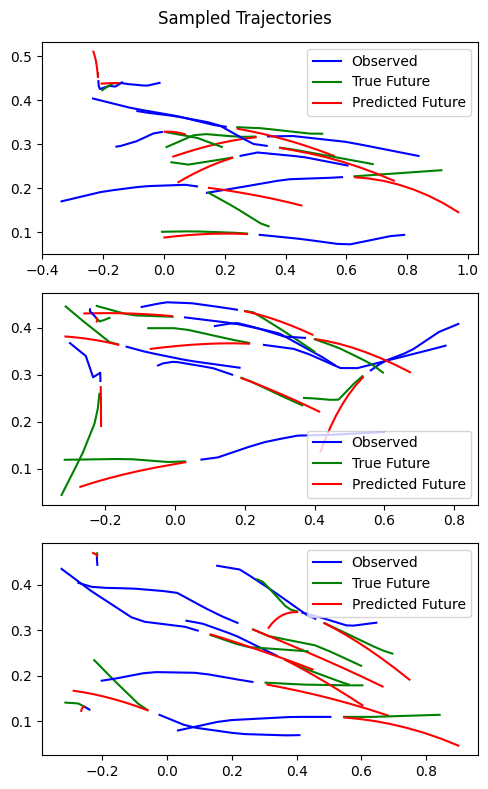

In [50]:
# Display sampled trajectories using function from above
display_sampled_trajectories(val_observed, val_future, predicted_val_future)

## 4.
Implementation of the second LSTM model that follows encoder-decoder network architecture.

In [63]:
import tensorflow as tf

# Encoder
encoder_inputs = tf.keras.layers.Input(shape=[12, 2])  # 12 frames of observed data
encoder = tf.keras.layers.LSTM(32, return_state=True)  # Use 32 units to match the decoder LSTM
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = tf.keras.layers.Input(shape=[1, 2])  # 1 frame at a time for prediction
decoder_lstm = tf.keras.layers.LSTM(32, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = tf.keras.layers.Dense(2)
decoder_outputs = decoder_dense(decoder_outputs)

model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 12, 2)]              0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 1, 2)]               0         []                            
                                                                                                  
 lstm_8 (LSTM)               [(None, 32),                 4480      ['input_7[0][0]']             
                              (None, 32),                                                         
                              (None, 32)]                                                         
                                                                                              

Compile and Train the Model with Early Stopping

In [65]:
model.compile(optimizer='adam', loss=ADE)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# We need to format the data in such a way that the LSTM gets the observed data as encoder input and
# the first frame of future data as the decoder input to predict the next step.
history = model.fit([train_observed, train_future[:, 0:1, :]], train_future[:, 1, :],
                    validation_data=([val_observed, val_future[:, 0:1, :]], val_future[:, 1, :]),
                    epochs=100, callbacks=[early_stop], batch_size=32)


Epoch 1/100
829/829 [==============================] - 15s 13ms/step - loss: 0.3411 - val_loss: 0.3128
Epoch 2/100
829/829 [==============================] - 8s 10ms/step - loss: 0.3366 - val_loss: 0.2902
Epoch 3/100
829/829 [==============================] - 7s 9ms/step - loss: 0.3364 - val_loss: 0.3050
Epoch 4/100
829/829 [==============================] - 9s 10ms/step - loss: 0.3364 - val_loss: 0.2841
Epoch 5/100
829/829 [==============================] - 7s 8ms/step - loss: 0.3363 - val_loss: 0.3015
Epoch 6/100
829/829 [==============================] - 9s 11ms/step - loss: 0.3363 - val_loss: 0.2973
Epoch 7/100
829/829 [==============================] - 11s 13ms/step - loss: 0.3364 - val_loss: 0.2979
Epoch 8/100
829/829 [==============================] - 10s 12ms/step - loss: 0.3362 - val_loss: 0.3006
Epoch 9/100
829/829 [==============================] - 9s 10ms/step - loss: 0.3362 - val_loss: 0.2892
Epoch 10/100
829/829 [==============================] - 9s 10ms/step - loss: 0.33

Display the Learning Curves

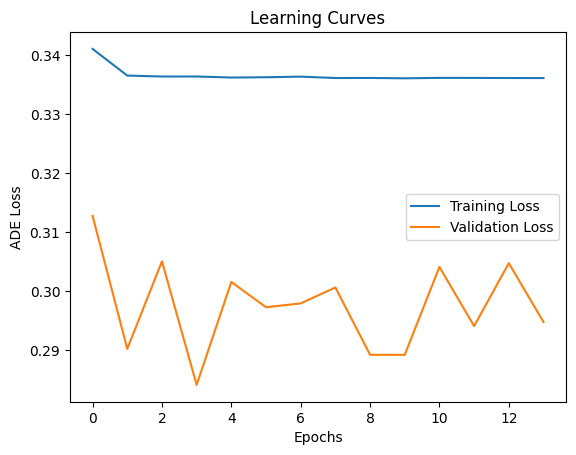

In [66]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('ADE Loss')
plt.title('Learning Curves')
plt.show()


Predict Remaining 7 Frames

In [67]:
def predict_future(model, observed, future_first_frame):
    predicted_future = np.zeros((observed.shape[0], 8, 2))
    current_input_frame = future_first_frame
    for i in range(8):
        next_step = model.predict([observed, current_input_frame])
        predicted_future[:, i, :] = next_step[:, 0, :]
        current_input_frame = next_step
    return predicted_future

predicted_val_future2 = predict_future(model, val_observed, val_future[:, 0:1, :])


73/73 [==============================] - 0s 3ms/step


Calculate ADE and FDE

In [68]:
ade = np.mean(np.sqrt(np.sum(np.square(val_future[:, 1:, :] - predicted_val_future2[:, 1:, :]), axis=-1)))
fde = np.mean(np.sqrt(np.sum(np.square(val_future[:, -1, :] - predicted_val_future2[:, -1, :]), axis=-1)))

print(f"ADE: {ade:.4f}")
print(f"FDE: {fde:.4f}")

ADE: 0.3476
FDE: 0.4075


Display sampled trajectories

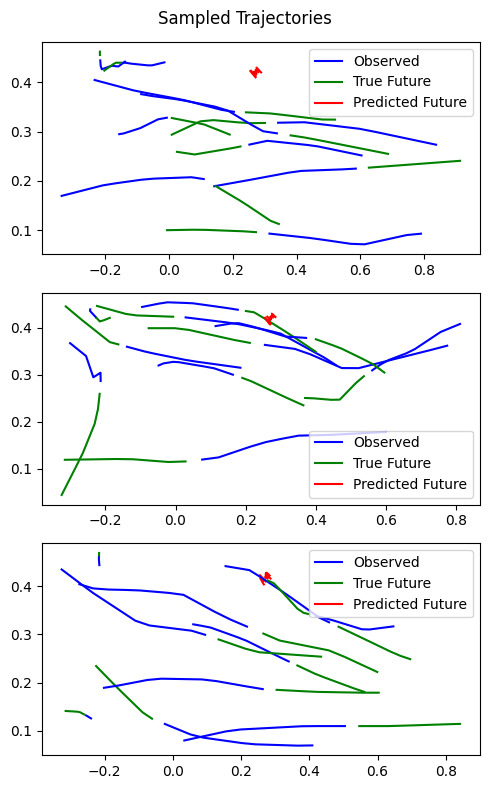

In [69]:
# Display sampled trajectories using function from above
display_sampled_trajectories(val_observed, val_future, predicted_val_future2)

## 5. Comparison

Compare the two LSTM models in terms of their numbers of parameters and performances
on the ADE and the FDE.

Change the lengths of the observed and future parts to 10/10, 8/12, and 6/142
and compare
how much the performances of both models drop with fewer observed timesteps and more
future timesteps.
Note that you should not need to change the architectures of the two LSTM networks, but
you would need to recompile and retrain the second LSTM model. You can put the code in a
function so that it can be reused for different split ratios of the trajectories.